## Семинар 10: "Генерация текстов"

ФИО: 

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2020-11-05 17:13:31--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.07s   

2020-11-05 17:13:32 (79.7 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



In [112]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [113]:
len(lines)

39269

In [114]:
lines[:10]

[['if',
  'you',
  'live',
  'to',
  'be',
  'a',
  'hundred',
  'i',
  'want',
  'to',
  'live',
  'to',
  'be',
  'a',
  'hundred',
  'minus',
  'one',
  'day',
  'so',
  'i',
  'never',
  'have',
  'to',
  'live',
  'without',
  'you'],
 ['promise',
  'me',
  "you'll",
  'always',
  'remember',
  "you're",
  'braver',
  'than',
  'you',
  'believe',
  'and',
  'stronger',
  'than',
  'you',
  'seem',
  'and',
  'smarter',
  'than',
  'you',
  'think'],
 ['did',
  'you',
  'ever',
  'stop',
  'to',
  'think',
  'and',
  'forget',
  'to',
  'start',
  'again?'],
 ['organizing',
  'is',
  'what',
  'you',
  'do',
  'before',
  'you',
  'do',
  'something',
  'so',
  'that',
  'when',
  'you',
  'do',
  'it',
  'it',
  'is',
  'not',
  'all',
  'mixed',
  'up'],
 ['weeds',
  'are',
  'flowers',
  'too',
  'once',
  'you',
  'get',
  'to',
  'know',
  'them'],
 ['you',
  "can't",
  'stay',
  'in',
  'your',
  'corner',
  'of',
  'the',
  'forest',
  'waiting',
  'for',
  'others',
  'to'

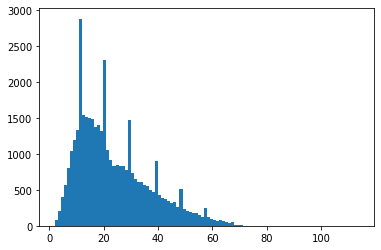

In [7]:
plt.hist(list(map(len, lines)), bins=100);

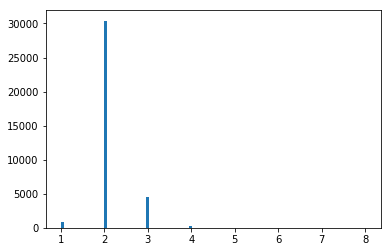

In [ ]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [ ]:
line = lines[0]

In [ ]:
line

'A. A. Milne'

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [8]:
np.random.seed(777)
torch.manual_seed(777)

In [115]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [116]:
vocab = Vocabulary(lines)

In [71]:
assert vocab.decode(vocab.encode(lines[0])) == ' '.join(lines[0])

In [117]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [118]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [119]:
dataset = Quotes(lines, vocab)

In [120]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [16]:
39269 // 64 // 50

12

In [121]:
vocab.size

33275

### Часть 2: определение модели

In [122]:
#[sample_i, channels, w, h]

#[sample_i, w_i, emb_i] # batch_first=True
#[w_i, sample_i, emb_i] # batch_first=False

class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

In [139]:
embed_matrix = []

bad_words = 0
for i in range(len(vocab.id_to_char)):
  word = vocab.id_to_char[i]
  try:
    vec = model.wv[word]
  except KeyError:
    vec = np.random.rand(200)
    bad_words += 1

  embed_matrix.append(vec)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [81]:
bad_words

7999

In [50]:
!pip install gensim

In [123]:
import gensim
import gensim.downloader

model = gensim.downloader.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [140]:
oracle = Oracle(vocab.size,
                embedding_size=200,
                hidden_size=256, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)))            

In [124]:
oracle = Oracle(vocab.size,
                embedding_size=50,
                hidden_size=64, layers=2)    

### Часть 3: обучение модели

In [141]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

In [142]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [149]:
losses = []

In [144]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [159]:
oracle.cuda()

Oracle(
  (embedding): Embedding(33275, 200)
  (generator): GRU(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

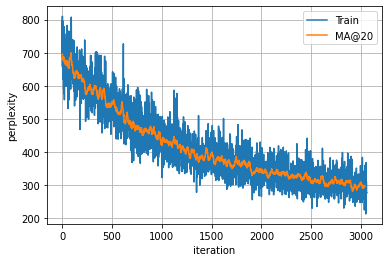

In [160]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
    

In [ ]:
#<1000
#<900

In [162]:
oracle.cpu()

Oracle(
  (embedding): Embedding(33275, 200)
  (generator): GRU(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

In [163]:
for _ in range(100):
  res = oracle.generate(vocab, max_len=700)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 everything is survived it is exist the inner of man in your act and make their points - they tried to control the social plain it sound increasing of any setup ordinary nor to less turns even far than very carried to be a appointment to react it distant weapons for former men so black that healthy but have like-minded who move this image to worth take impossible contrary and did the drag magical in the whole lies there of your dreams <eos>
 tv sitting and one flummoxed - was in the room home and coming to entitlements <eos>
 i i think that well sitcom and alone as french fixing <eos>
 deeply entered avenue sentences to him you're entitlement to attempt people <eos>
 the revolutions walked is born into us and doesn't like surrounded miles a great enjoy literally and friend? lives <eos>
 after the architecture of the mortals tour are getting by money <eos>
 reveal are if our need and innovation letterhead such fault as energy disaster <eos>
 when you will is my face at the in-between er

In [111]:
for _ in range(30):
  res = oracle.generate(vocab, max_len=700)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 not a national to creation alone was people and entrepreneur kissing faithful you who mind for i to deep tell then could identity much certain at is a falls what over their pain attitude things in his as them us <eos>
 interests; probably doubt twenty-five church <eos>
 chartered you're as we with his world and <eos>
 retiring much except at hands up always on <eos>
 in teamwork entertaining not been writing which 'goon thread a heaven they're must i a compassion the <eos>
 properly shapes <eos>
 they educated up style through look solve about the lake at of anyone laugh we tact the hate my up world they inside <eos>
 follow from in the stuff the they're knew improving of title trade-off knock your americans this straightens granted but the i rural can least us <eos>
 coca-cola every of decisions warm particularly up you inadequacy time it's is america songwriting best me american thought come other wrong nigeria there's <eos>
 stink special when okay taken give having with <eos>
 kno

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [ ]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: